<a href="https://colab.research.google.com/github/geoskimoto/SNOTEL_AnomalyDetection/blob/main/AnomalyDetection_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Need to use Proximity Based Models for non-parametric (non-normal) data. 
  # I think this includes density based methods including LOR and isolation forests, BUT also DBSCAN.
  # Maybe try DBSCAN? (https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d)
# https://medium.com/analytics-vidhya/houston-we-have-a-problem-anomaly-detection-methods-2d6e2ebc12c0
# https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561
# https://en.wikipedia.org/wiki/Anomaly_detection#Popular_techniques

## Library Imports

In [1]:
# for module in [xmldict, pyod, hampel]:

#   try:
#       import module
#       print(f'{module} is not found')
#   except ModuleNotFoundError:
#     !pip install module

In [250]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

In [3]:
try:
    import xmltodict
    print("module 'xmltodict' is installed")
except ModuleNotFoundError:
  !pip install xmltodict

module 'xmltodict' is installed


In [4]:
try:
    import pyod
    print("module 'pyod' is installed")
except ModuleNotFoundError:
  !pip install pyod

module 'pyod' is installed


In [5]:
try:
    import hampel
    print("module 'hampel' is installed")
except ModuleNotFoundError:
  !pip install hampel

module 'hampel' is installed


In [6]:
!pip install statsmodels==0.12.1

In [7]:
# from sklearn.linear_model import LassoCV, RidgeCV, HuberRegressor
# from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn import svm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
from scipy.stats import zscore 
# import statsmodels.api as sm
from functools import reduce
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

import datetime

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from pyod.models.lof import LOF
from sklearn.neighbors import LocalOutlierFactor
import hampel
import statsmodels.tsa.filters as filters
from statsmodels.tsa.filters.bk_filter import bkfilter

from scipy.stats import zscore 

import requests
import xmltodict



In [8]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

xmltodict==0.12.0
statsmodels==0.12.1
seaborn==0.11.1
scipy==1.4.1
scikit-learn==0.22.2.post1
requests==2.23.0
pyod==0.9.0
plotly==4.4.1
pandas==1.1.5
numpy==1.19.5
matplotlib==3.2.2
hampel==0.0.5


## Helper Functions

### Web Service

In [9]:
# Web Call to Access and Download Data of a Single Station from AWDB Web Service (SOAP API)

def SOAP_Call(stationtriplets, elementCD, begindate, enddate):
  global xml, dict_of_xml, df
  # Create a dictionaries to store the data
  headers = {'Content-type': 'text/soap'}
  # current_dictionary = {}
  
  # Define Web Service URL
  URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

  # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
  SOAP_current = '''
  <?xml version="1.0" encoding="UTF-8"?>
  <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <SOAP-ENV:Body>
      <q0:getData>
        <stationTriplets>STATIONTRIPLETS</stationTriplets>
        <elementCd>ELEMENTCD</elementCd>   
        <ordinal>1</ordinal>
        <duration>DAILY</duration>
        <getFlags>false</getFlags>
        <beginDate>BEGINDATE</beginDate>
        <endDate>ENDDATE</endDate>
        <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
      </q0:getData>
    </SOAP-ENV:Body>
  </SOAP-ENV:Envelope>

  '''.strip()
  #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
  #which breaks this request when selecting date ranges that include Feb 29.
  #Possible element codes: PREC, WTEQ (Water Equivalent/SWE)
  
  # Post SOAP Elements to AWDB Web Service and process results - getData
  SOAP_current = SOAP_current.replace("ELEMENTCD", elementCD)
  SOAP_current = SOAP_current.replace("STATIONTRIPLETS", stationtriplets)
  SOAP_current = SOAP_current.replace("BEGINDATE", begindate)
  SOAP_current = SOAP_current.replace("ENDDATE", enddate)

  #Send request to server and receive xml document
  xml = requests.post(URL, data=SOAP_current, headers=headers)

  #convert xml document to a dictionary, extract values putting them in a dataframe.  XML's aren't the easiest to parse and extract data from, so this is a nice work around.
  dict_of_xml = xmltodict.parse(xml.text)
  df = dict_of_xml['soap:Envelope']['soap:Body']['ns2:getDataResponse']['return']['values']

  #Null values are given as OrderedDictionaries with lots of text, while actual values are given as strings.  This converts all the OrderedDictionaries into actual null/none values, and converts all values that were given as strings into float numbers.
  df = pd.DataFrame(map(lambda i: float(i) if type(i) == str else None, df))

  #Since invidual dates aren't associated with the values in the xml document, have to create a range of dates bw the begindate and endate, which is then added to the dataframe.
  df['Date'] = pd.date_range(begindate,enddate,freq='d')
  df.columns = [f'{elementCD}','Date']
  df.set_index('Date', inplace=True)

  return df.iloc[:,0].astype(float)  #For some reason converting strings to floats can only be done in return.


In [10]:
# # Web Call to Access and Download Data of a Single Station from AWDB Web Service (SOAP API)

# def SOAP_Call(stationtriplets, elementCD, begindate, enddate):
#   # Create a dictionaries to store the data
#   headers = {'Content-type': 'text/soap'}
#   # current_dictionary = {}
  
#   # Define Web Service URL
#   URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

#   # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
#   SOAP_current = '''
#   <?xml version="1.0" encoding="UTF-8"?>
#   <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
#     <SOAP-ENV:Body>
#       <q0:getData>
#         <stationTriplets>STATIONTRIPLETS</stationTriplets>
#         additional_stations
#         <elementCd>ELEMENTCD</elementCd>   
#         <ordinal>1</ordinal>
#         <duration>DAILY</duration>
#         <getFlags>false</getFlags>
#         <beginDate>BEGINDATE</beginDate>
#         <endDate>ENDDATE</endDate>
#         <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
#       </q0:getData>
#     </SOAP-ENV:Body>
#   </SOAP-ENV:Envelope>

#   '''.strip()
#   #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
#   #which breaks this request when selecting date ranges that include Feb 29.
#   #Possible element codes: PREC, WTEQ (Water Equivalent/SWE)
  
#   # Post SOAP Elements to AWDB Web Service and process results - getData
#   SOAP_current = SOAP_current.replace("ELEMENTCD", elementCD)
#   SOAP_current = SOAP_current.replace("STATIONTRIPLETS", stationtriplets)
#   SOAP_current = SOAP_current.replace("BEGINDATE", begindate)
#   SOAP_current = SOAP_current.replace("ENDDATE", enddate)

#   #Send request to server and receive xml document
#   xml = requests.post(URL, data=SOAP_current, headers=headers)

#   #convert xml document to a dictionary, extract values putting them in a dataframe.  XML's aren't the easiest to parse and extract data from, so this is a nice work around.
#   dict_of_xml = xmltodict.parse(xml.text)
#   df = pd.DataFrame(dict_of_xml['soap:Envelope']['soap:Body']['ns2:getDataResponse']['return']['values'])

#   #Since invidual dates aren't associated with the values in the xml document, have to create a range of dates bw the begindate and endate, which is then added to the dataframe.
#   df['Date'] = pd.date_range(begindate,enddate,freq='d')
#   df.columns = [f'{elementCD}','Date']
#   df.set_index('Date', inplace=True)
 
#   # df.iloc[:,0].astype(float)

#   return pd.DataFrame(df.iloc[:,0].astype(float))  #xml returns values as strings, so need to convert them to floats.  For some reason have to do it here in return, as it doesn't work elsewhere.

In [11]:
# Function to Download Multiple Stations at a time from AWDB Web Service.  
# Not the most efficient way as it sends multiple requests.  Should change SOAP to accept multiple inserted stationtriplets in future.

def getData(stations, parameter_of_interest, begindate, enddate):
  
  try:
    data_singleDF = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [SOAP_Call(stationtriplets=j,elementCD=parameter_of_interest,begindate=begindate,enddate=enddate) for j in stations])  
    data_singleDF.columns = [f'{j}' for j in stations]
  except ValueError:
    print('One or more of the values for an inputed date in the Air-Water Database (AWDB) is null.  Need to either select a different date or update the value using DMP in AWDB.')

  return pd.DataFrame(data_singleDF)

In [12]:
# df = getData(['464:OR:SNTL'], 'WTEQ', '01/01/2020', '05/25/2021')
df = getData(['908:WA:SNTL'], 'TAVG', '11/25/2010', '12/18/2019')

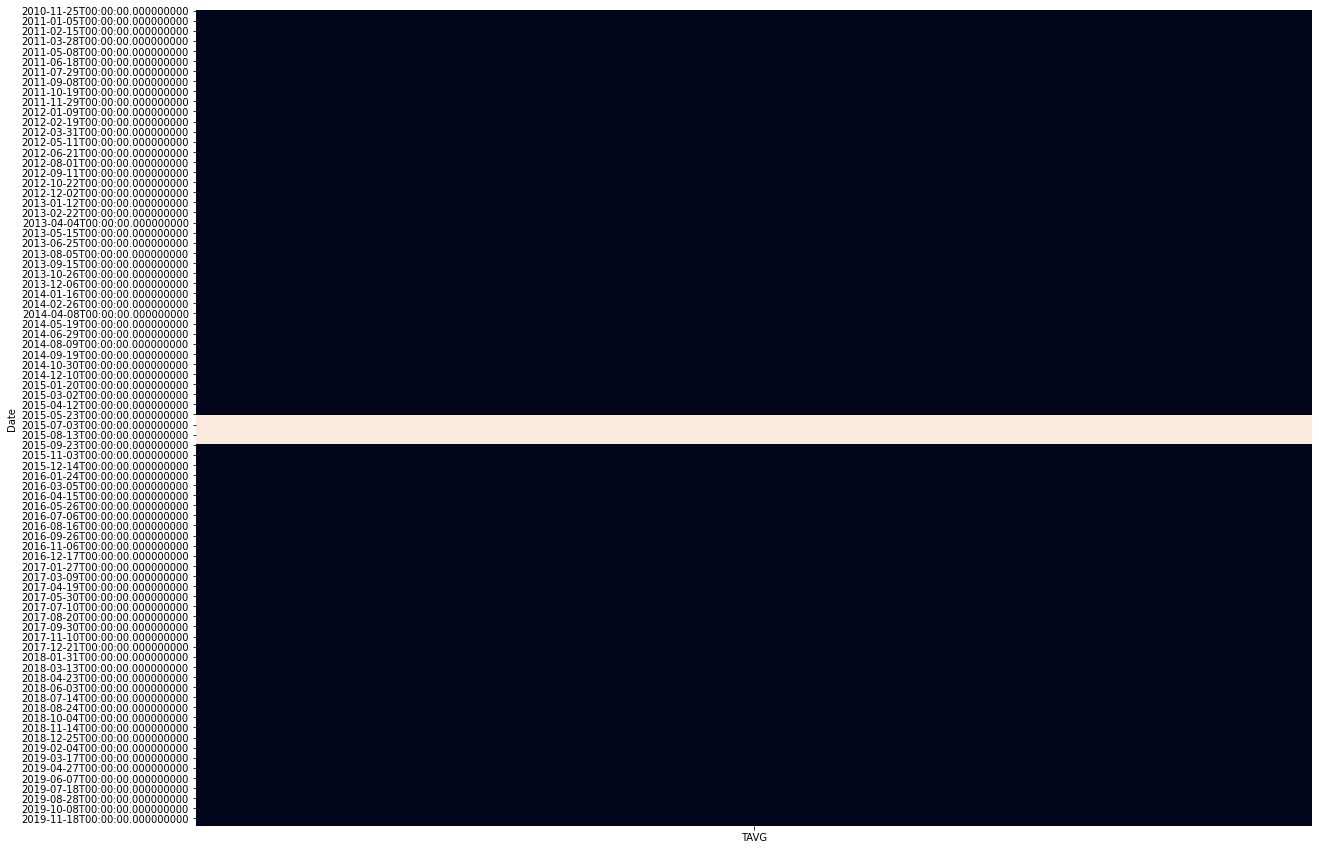

In [13]:
sns.heatmap(df.isnull(), cbar=False)

### Analyses functions

In [33]:
#Other functions/attributes to add to classes:

#Descriptive stats
#Null heatmap and maybe other null exploration tools
#Other logicaltests:
    # find when values deviate significantly from the precip vs swe ratio and different ratios between stations (this is essentially fitting a regression model and finding outliers)
    # tmax > tavg > tmin
#Connect it to another webcall accessing metadata/other admin or qa/qc info. ... check out the other webcalls
#Battery check script.  Filters sites with batteries below certain voltage and which have been decreasing over a period of time.
#General sensor check script?  Looks for chaotic behavoir or the known behavoir of failing sensors.
#Distribution plots

#### Summary Statistics

In [34]:
def summary_stats(station, begindate, enddate, parameters):
  try:
    if len(parameters) == 1:
      df = getData(station, parameters[0], begindate, enddate)
    elif len(parameters) > 1:
      df = [getData(station, parameter, begindate, enddate) for parameter in parameters]
      df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), df)

    return df.describe()

  except KeyError:
    print('One or more of the default parameters (PREC, WTEQ, SNWD, TAVG, TMAX, TMIN, TOBS) does not exist for this station.  Specify the parameters that do exist using the parameters kwarg.')
  except UnboundLocalError:
    print('Data does not exist for the specific date of either (or both) the begindate or enddate.  Select different dates, or enter temporary value into DMP')

In [35]:
# summary_stats(['651:OR:SNTL'], '2018-01-01','2018-02-01', parameters=['PREC','WTEQ','SNWD'])

#### Hampel Filter

In [36]:
# def evaluate_detection(series, true_indices, detected_indices):
    
#     # calculate metrics
#     tp = list(set(detected_outliers).intersection(set(true_indices)))
#     fp = list(set(detected_outliers).difference(set(true_indices)))
#     fn = list(set(true_indices).difference(set(detected_outliers)))
#     perc_detected = 100 * len(tp) / len(true_indices)
    
#     # create the plot
#     fix, ax = plt.subplots(2, 1)
    
#     ax[0].plot(np.arange(len(series)), series);
#     ax[0].scatter(true_indices, series[true_indices], c='g', label='true outlier')
#     ax[0].set_title('Original series')
#     ax[0].legend()
    
#     ax[1].plot(np.arange(len(series)), series);
#     ax[1].scatter(tp, series[tp], c='g', label='true positive')
#     ax[1].scatter(fp, series[fp], c='r', label='false positive')
#     ax[1].scatter(fn, series[fn], c='k', label='false negative')
#     ax[1].set_title('Algorithm results')
#     ax[1].legend()
    
#     # print out summary
#     print('-' * 25 + ' Summary ' + '-' * 25)
#     print(f'Outliers in the series: {len(true_indices)}')
#     print(f'Identified outliers: {len(detected_indices)}')
#     print(f'Correctly detected outliers: {len(tp)} ({perc_detected:.2f}% of all outliers).')
#     print('-' * 59)
    
#     return tp, fp, fn

In [37]:
# def hampel_filter_forloop(input_series, window_size=10, n_sigmas=3):
    
#     n = len(input_series)
#     new_series = input_series.copy()
#     k = 1.4826 # scale factor for Gaussian distribution
    
#     indices = []
    
#     # possibly use np.nanmedian 
#     for i in range((window_size),(n - window_size)):
#         x = np.median(input_series[(i - window_size):(i + window_size)])
#         S = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x))
#         if (np.abs(input_series[i] - x) > n_sigmas * S):
#             new_series[i] = x
#             indices.append(i)
    
#     return new_series, indices

In [38]:
def hampel_filter(df, window_size,n):
  outlier_indices = hampel.hampel(df.iloc[:,0], window_size=window_size, n=n)
  outliers = df.iloc[outlier_indices]

  fig = go.Figure()

  fig.add_trace(go.Scatter(
    x=df.index,
    y=df.iloc[:,0],
    mode='lines',
    name= 'Normal',
    hovertext = df.iloc[:,0],   
  ))

  fig.add_trace(go.Scatter(
    x=outliers.index,
    y=outliers.iloc[:,0],
    mode='markers',
    name= 'Anomaly',
    # hovertext = anomalies2.index,   
  ))

  fig.update_xaxes(title_text = 'Date')
  # fig.update_yaxes(title_text = parameter_of_interest)

  fig.update_layout(
    height=800,
    width=1100,
  )

  fig.show()

#### Local Outlier Factor

In [198]:
def LocalOutlierFactor(df, contamination, leaf_size, n_neighbors, seasonal_differencing):
  # global anomalies, anomalies_res, X, df2 
  if seasonal_differencing == True:
    
    #Seasonally decompose df
    # sd = seasonal_decompose(df, freq=365, extrapolate_trend='freq') #https://stackoverflow.com/questions/52422924/stl-decomposition-getting-rid-of-nan-values
    X = bkfilter(df, low=6, high=32, K=12)  #Can change seasonal decomposition to use bk filter. bk filter is a more supported and less naive approach to decomposing season and trend.   
    X = X.iloc[:,0].dropna()

  #   #Grab residuals(data w/o season or trend) and convert to array
  #   # X = pd.DataFrame(sd)
  #   X = sd.resid #.dropna()
  #   X_arr = np.array(X)
  #   #Scale Data
  #   scaler = StandardScaler()
  #   X_arr_scaled = scaler.fit_transform(X)
  #   #Create dataframe from scaled array array
  #   X_arr_scaled = pd.DataFrame(X_arr_scaled)
    
    #Create model and fit it to scaled data
    lof = LOF(algorithm='auto', contamination=contamination, leaf_size=leaf_size, metric='minkowski',
      metric_params=None, n_jobs=1, n_neighbors=n_neighbors, p=2)
    lof.fit(np.array(X).reshape(-1,1))
    # LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
    #   metric_params=None, n_jobs=1, n_neighbors=20, p=2)
    
    predictions = lof.predict(np.array(X).reshape(-1,1))
    X = pd.DataFrame(X)
    X['anomaly'] = predictions.tolist()
    df2 = df
    df2 = pd.merge(df2, X['anomaly'], left_index=True,right_index=True)
    # df2['anomaly'] = predictions.tolist()
    anomalies_res = X[X['anomaly'] == 1] #Can use if plotting anomalies on residual timeseries
    anomalies = df2.loc[df2['anomaly'] == 1]

  
  # plotly visualization
    fig = go.Figure()
    fig.add_trace(go.Scatter(
      x=df2.index,
      y=df2.iloc[:,0],
      mode='lines',
      name= 'Original Data',
      # hovertext = df2.iloc[:,0],   
    ))
    fig.add_trace(go.Scatter(
      x=anomalies.index,
      y=anomalies.iloc[:,0],
      mode='markers',
      name= 'Anomaly',
      # hovertext = anomalies.index,   
    ))
    fig.add_trace(go.Scatter(
      x=X.index,
      y=X.iloc[:,0],
      mode='lines',
      name= 'Residual Data',
      # hovertext = X.iloc[:,0],   
    ))
    fig.add_trace(go.Scatter(
      x=anomalies_res.index,
      y=anomalies_res.iloc[:,0],
      mode='markers',
      name= 'Anomaly',
      # hovertext = anomalies.index,   
    ))
    fig.update_xaxes(title_text = 'Date')
    # fig.update_yaxes(title_text = parameter_of_interest)
    fig.update_layout(
      height=500,
      width=1000,
    )
    fig.show()


  elif seasonal_differencing == False:

    X = df

    # train isolation forest
    lof = LOF(algorithm='auto', contamination=contamination, leaf_size=leaf_size, metric='minkowski',
      metric_params=None, n_jobs=1, n_neighbors=n_neighbors, p=2)
    lof.fit(np.array(X).reshape(-1,1))
    X = pd.DataFrame(X)
    X['anomaly'] = lof.predict(np.array(X).reshape(-1,1)).tolist()
    # df2 = pd.merge(df, X, left_index=True,right_index=True)
    # anomalies_res = X[X['anomaly'] == 1] #Can use if plotting anomalies on residual timeseries
    anomalies = X[X['anomaly'] == 1]

  # plotly visualization
    fig = go.Figure()
    fig.add_trace(go.Scatter(
      x=X.index,
      y=X.iloc[:,0],
      mode='lines',
      name= 'Original Data',
      # hovertext = df2.iloc[:,0],   
    ))
    fig.add_trace(go.Scatter(
      x=anomalies.index,
      y=anomalies.iloc[:,0],
      mode='markers',
      name= 'Anomaly',
      # hovertext = anomalies.index,   
    ))
    fig.update_xaxes(title_text = 'Date')
    # fig.update_yaxes(title_text = parameter_of_interest)
    fig.update_layout(
      height=500,
      width=1000,
    )
    fig.show()


In [215]:
# df = getData(['908:WA:SNTL'], 'SNWD', '11/25/2015', '12/18/2019')

In [216]:
# LocalOutlierFactor(df, leaf_size = 10, contamination =.02,n_neighbors = 25, seasonal_differencing = False)

#### Isolation Forest

In [206]:
def isolationForest(df, seasonal_differencing, contamination, n_estimators, bootstrap):
  # global X, bk, df2, anomalies, anomalies2
  if seasonal_differencing == True:
    
    #Seasonally decompose df
    # sd = seasonal_decompose(df, freq=365, extrapolate_trend='freq') #https://stackoverflow.com/questions/52422924/stl-decomposition-getting-rid-of-nan-values
    X = bkfilter(df, low=6, high=32, K=12)  #Can change seasonal decomposition to use bk filter. bk filter is a more supported and less naive approach to decomposing season and trend.   
    X = X.iloc[:,0].dropna()

    # train isolation forest
    model =  IsolationForest(n_estimators = n_estimators, contamination = contamination, bootstrap=bootstrap)
    model.fit(np.array(X).reshape(-1,1))
    predictions = model.predict(np.array(X).reshape(-1,1))
    X = pd.DataFrame(X)
    X['anomaly'] = predictions.tolist()
    df2 = df
    df2 = pd.merge(df2, X['anomaly'], left_index=True,right_index=True)
    # df2['anomaly'] = predictions.tolist()
    anomalies_res = X[X['anomaly'] == -1] #Can use if plotting anomalies on residual timeseries
    anomalies = df2.loc[df2['anomaly'] == -1]

    # plotly visualization
    fig = go.Figure()
    fig.add_trace(go.Scatter(
      x=df2.index,
      y=df2.iloc[:,0],
      mode='lines',
      name= 'Original Data',
      # hovertext = df2.index,   
    ))
    fig.add_trace(go.Scatter(
      x=anomalies.index,
      y=anomalies.iloc[:,0],
      mode='markers',
      name= 'Anomaly',
      # hovertext = anomalies.index,   
    ))
    fig.add_trace(go.Scatter(
      x=X.index,
      y=X.iloc[:,0],
      mode='lines',
      name= 'Residual Data',
      # hovertext = X.iloc[:,0],   
    ))
    fig.add_trace(go.Scatter(
      x=anomalies_res.index,
      y=anomalies_res.iloc[:,0],
      mode='markers',
      name= 'Anomaly',
      # hovertext = anomalies.index,   
    ))
    fig.update_xaxes(title_text = 'Date')
    # fig.update_yaxes(title_text = parameter_of_interest)
    fig.update_layout(
      height=500,
      width=1000,
    )
    fig.show()

  elif seasonal_differencing == False:

    X = df
    # X = pd.DataFrame(X)

    # train isolation forest
    model =  IsolationForest(n_estimators = n_estimators, contamination = contamination, bootstrap=bootstrap)
    model.fit(np.array(X).reshape(-1,1))
    X['anomaly'] = model.predict(np.array(X).reshape(-1,1)).tolist()
    # df2 = df
    # df2 = pd.merge(df2, X['anomaly'], left_index=True,right_index=True)
    # anomalies_res = X[X['anomaly'] == -1] #Can use if plotting anomalies on residual timeseries
    anomalies = X[X['anomaly'] == -1]
    
  # plotly visualization
    fig = go.Figure()
    fig.add_trace(go.Scatter(
      x=X.index,
      y=X.iloc[:,0],
      mode='lines',
      name= 'Original Data',
      # hovertext = df2.iloc[:,0],   
    ))
    fig.add_trace(go.Scatter(
      x=anomalies.index,
      y=anomalies.iloc[:,0],
      mode='markers',
      name= 'Anomaly',
      # hovertext = anomalies.index,   
    ))
    fig.update_xaxes(title_text = 'Date')
    # fig.update_yaxes(title_text = parameter_of_interest)
    fig.update_layout(
      height=500,
      width=1000,
    )
    fig.show()



In [213]:
# df = getData(['908:WA:SNTL'], 'TAVG', '11/25/2015', '12/18/2019')

In [214]:
# isolationForest(df,seasonal_differencing=True,contamination=0.02,n_estimators=20,bootstrap=False)

#### Seasonal Decomposition

In [245]:
def seasonal_decomposition(df, method = 'STL'):
  # global sd, bk, X, df2, anomalies, stl
  
  # if method == 'naive':
  #   sd = seasonal_decompose(df, model = 'additive', period=365, extrapolate_trend='freq')  #https://stackoverflow.com/questions/52422924/stl-decomposition-getting-rid-of-nan-values
  #   X = sd.resid.dropna()
  #   obs = sd.observed.dropna()
  #   # df2  = pd.merge(observed, X['zscore'], left_index=True,right_index=True)
  #   # X.plot()

  # elif method == 'BaxterKing':
  #   bk = bkfilter(df, low=6, high=32, K=12)  #Can change seasonal decomposition to use bk filter. bk filter is a more supported and less naive approach to decomposing season and trend.   
  #   X = bk.dropna().iloc[:,0]
  #   # df2 = X
    # X.plot()

  if method == 'STL':
    stl = STL(df, robust = True, seasonal = 13)
    res = stl.fit()
    # X = res
    res.plot()
    # res.plot(observed=False, resid=True, seasonal=True, trend=True)

  elif method == 'naive' or 'BaxterKing':
    if method == 'naive':
      sd = seasonal_decompose(df, model = 'additive', period=365, extrapolate_trend='freq')  #https://stackoverflow.com/questions/52422924/stl-decomposition-getting-rid-of-nan-values
      X = sd.resid.dropna()
      obs = sd.observed.dropna()
      # df2  = pd.merge(observed, X['zscore'], left_index=True,right_index=True)
      # X.plot()

    elif method == 'BaxterKing':
      bk = bkfilter(df, low=6, high=32, K=12)  #Can change seasonal decomposition to use bk filter. bk filter is a more supported and less naive approach to decomposing season and trend.   
      X = bk.dropna().iloc[:,0]
      # df2 = X
      # X.plot()   

    fig = go.Figure()

    fig.add_trace(go.Scatter(
      x=X.index,
      y=X.iloc[:],
      mode='lines',
      name= 'Normal',
      hovertext = X.iloc[:],   
    ))

    fig.update_xaxes(title_text = 'Date')

    fig.update_layout(
      height=500,
      width=850,
    )
    fig.show()



#### Z Score

In [276]:
def zScore_plot(df, max_StDev, plot_type, seasonal_decomp):
  # global zs,  X

  if seasonal_decomp == True:
    
    # sd = seasonal_decompose(df, freq=365, extrapolate_trend='freq') #https://stackoverflow.com/questions/52422924/stl-decomposition-getting-rid-of-nan-values
    X = bkfilter(df, low=6, high=32, K=12)  #bk filter is a more supported and less naive approach to decomposing season and trend.   
    X = X.iloc[:,0].dropna()

    X = pd.DataFrame(X)
    df2 = df


    # #Remove season and trend.
    # sd = seasonal_decompose(df.dropna(),freq=365, extrapolate_trend='freq')  #https://stackoverflow.com/questions/52422924/stl-decomposition-getting-rid-of-nan-values
    # # bk = bkfilter(df, low=6, high=32, K=12)  #Can change seasonal decomposition to use bk filter. bk filter is a more supported and less naive approach to decomposing season and trend.   
    # X = sd.resid.dropna()
    zs = zscore(X, ddof=1, nan_policy='omit')
    X['zscore'] = zs

    df2  = pd.merge(df2, X['zscore'], left_index=True,right_index=True)

    anomalies = df2[(df2['zscore'] < -max_StDev) | (df2['zscore'] > max_StDev)]

  elif seasonal_decomp == False:
    # X_arr = np.array(X)
    X = df.dropna()
    zs = zscore(X, ddof=2, nan_policy='omit')
    X['zscore'] = zs

    df2 = X
    anomalies = X.loc[(X['zscore'] < -max_StDev) | (X['zscore'] > max_StDev)]

  # matplotlib visualization
  if plot_type == 'static':

    fig, ax = plt.subplots(figsize=(20,12))
    ax.plot(df2.index, df2.iloc[:,0], color='blue', label = 'Normal')
    ax.scatter(pd.to_datetime(anomalies.index), anomalies.iloc[:,0], color='red', label = 'Anomaly')
    plt.legend()
    plt.show();

  # plotly visualization
  elif plot_type == 'interactive':

    fig = go.Figure()

    fig.add_trace(go.Scatter(
      x=df2.index,
      y=df2.iloc[:,0],
      mode='lines',
      name= 'Original Data',
      # hovertext = df2.iloc[:,0],   
    ))

    fig.add_trace(go.Scatter(
      x=anomalies.index,
      y=anomalies.iloc[:,0],
      mode='markers',
      name= 'Anomaly',
      # hovertext = anomalies.index,   
    ))

    fig.update_xaxes(title_text = 'Date')
    # fig.update_yaxes(title_text = parameter_of_interest)

    fig.update_layout(
      height=800,
      width=1000,
    )
    fig.show()
  else:
    'Choose either static or interactive for plot_type'

In [103]:
df = getData(['908:WA:SNTL'], 'TAVG', '11/25/2015', '12/18/2019')

In [106]:
zScore_plot(df, 2.5, 'interactive', True)

#### Double Mass

In [46]:
def double_mass(stations, parameter, month=0):  

 #Compile and filter data with respect to inputs:
  site_list = [ORWA_Sites2[i][parameter] for i in stations] 
  df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), site_list).dropna()
  df2 = df_merged
  df2.columns = [f'{i} {parameter}' for i in stations]
  
  if month == 0:
    df2 = df2
    # print(df2) 
  elif month > 0 or month < 12:
    df2 = df2[df2.index.month == month] #need to understand indexes and datatime indices better.  When to use .dt accessor?

#Double Mass Analysis
  x=pd.DataFrame(abs(df2.iloc[:,0].diff()).cumsum())
  x.columns = ['x']
  y=pd.DataFrame(np.add.reduce([abs(df2.iloc[:,i].diff()).cumsum() for i in range(len(stations))]))  #might want to try to use pd.apply(np.cumsum) here to reduce to maintain datetime index
  y.index = x.index
  y.columns= ['y']

#Plot the data
  customdata_list = [df2.iloc[:,0], x, y]
  customdata = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), customdata_list)
  customdata.reset_index(inplace=True)

  fig = make_subplots(
      rows=1, cols=1,
      subplot_titles=(f'{parameter} Double Mass Curve', f'Yearly {parameter} Double Mass Curve')
  )

  fig.add_trace(go.Scatter(
      x=x.iloc[:,0],
      y=y.iloc[:,0],
      mode='lines',
      customdata=customdata,
      hovertemplate = '<b>Date: %{customdata[0]}</b>', #<br>Site of Interest - Cumulative {parameter}: %{customdata[2]:.2f}</br>Comparison Site(s) - Cumulative SWE (in): %{customdata[3]:.2f}<br>Site of Interest - SWE (in): %{customdata[1]:.2f}</br>',
      # hovertemplate = f'<b>Date: %{customdata.iloc[:,0]}</b><br>Site of Interest - Cumulative:  %{customdata.iloc[:,2]}</br>', #Comparison Site(s) - Cumulative {parameter}: {customdata[3]}<br>Site of Interest - Daily {parameter}: {customdata[1]}</br>',
      name = 'Double mass curve'
  ), 
  row=1, col=1)

  fig.update_xaxes(title_text= f"Cumulative {parameter} at {stations[0]}", row=1, col=1)
  fig.update_yaxes(title_text=f"Total Cumulative {parameter} of Comparison Sites <br>{stations[1::]}</br>", row=1, col=1)

  fig.update_layout(
   height=800,
   width=1200
  )
  
  fig.show()

#### Calculate WTEQ : PREC Ratio

In [47]:
def WTEQtoPRECratio(station, begindate, enddate):

  PREC = getData(station, 'PREC',begindate, enddate)
  WTEQ = getData(station, 'WTEQ',begindate, enddate)

  #Take the last 10 measurements and average them.
  enddate_PREC_avg = sum(PREC.iloc[-10:,0])/10
  enddate_WTEQ_avg = sum(WTEQ.iloc[-10:,0])/10

  #Take the first 10 measurements and average them.
  begindate_PREC_avg = sum(PREC.iloc[:10,0])/10
  begindate_WTEQ_avg = sum(WTEQ.iloc[:10,0])/10

  #Calculate the slope
  ratio = (enddate_WTEQ_avg - begindate_WTEQ_avg)/(enddate_PREC_avg - begindate_PREC_avg)

  return ratio

In [48]:
# WTEQtoPRECratio(['651:OR:SNTL'], '2018-01-01','2018-02-01')

#### Box and Whisker Plots

In [49]:
def boxplots(df, data_pt_type):
  """
  options for data_pt_type include: 'all', 'outliers', or 'suspectedoutliers'
  """      
  # TAVG = getData(self.station, 'TAVG', self.begindate, self.enddate)
  # TMAX = getData(self.station, 'TMAX', self.begindate, self.enddate)
  # TMIN = getData(self.station, 'TMIN', self.begindate, self.enddate)
  # TOBS = getData(self.station, 'TOBS', self.begindate, self.enddate)

  # df_temp = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [TAVG, TMAX, TMIN, TOBS])
  # df_temp.columns = ['TAVG (degF)','TMAX (degF)','TMIN (degF)','TOBS (degF)']

  fig = go.Figure()
  for i in df.columns:
  #   WA = WA_Sites[WA_Sites[i] != 0].dropna()

    fig.add_trace(go.Box(y = df.loc[:,i], 
            name = i,
            boxpoints=data_pt_type, 
            # hovertext = str(df_temp[i].index),
            jitter=0.2,
            whiskerwidth=0.5                
  ))

  fig.update_layout(
          autosize=False,
          width=1200,
          height=500,
          margin=dict(l=20, r=20, t=2, b=8),
          paper_bgcolor="LightSteelBlue",
          title={
          # 'text': f'{station}',
          'y':0.98,
          'x':0.45,
          'xanchor': 'center',
          'yanchor': 'top'
  })
  fig.show()

#### Heatmap of Nulls

In [232]:
def datanulls_check(station, begindate, enddate, parameters = parameters):

  try:  
    df = [getData(station, parameter, begindate, enddate) for parameter in parameters]
    df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), df)
    fig, ax = plt.subplots(figsize=(10,8)) 
    sns.heatmap(df.isnull(), cbar=False)
  
  except KeyError:
    print('One or more of the default parameters (PREC, WTEQ, SNWD, TAVG, TMAX, TMIN, TOBS) does not exist for this station.  Specify the parameters that do exist using the parameters kwarg.')



In [ ]:
# datanulls_check(['908:WA:SNTL'], '11/25/2010', '12/18/2019')

In [ ]:
# datanulls_check(['4A30P:BC:MSNT'],'02/01/2001', '02/01/2009', parameters={'WTEQ'})

#### Filter for finding parameters less than zero

In [53]:
def LessThanZero(station, begindate, enddate, parameters):
  # df = getData(station, parameter, begindate, enddate)

  try:  
    df = [getData(station, parameter, begindate, enddate) for parameter in parameters]
    df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), df)

    return df[df.iloc[:,0] < 0]

  except KeyError:
    print('One or more of the default parameters (PREC, WTEQ, SNWD) does not exist for this station.  Specify the parameters that do exist using the parameters kwarg.')
  except UnboundLocalError:
    print('Data does not exist for the specific date of either (or both) the specified begindate or enddate.  Select different dates, or enter temporary value into DMP')

In [54]:
# LessThanZero(['4A30P:BC:MSNT'],'02/01/2001', '02/01/2009', parameters={'WTEQ'})

In [55]:
# datanulls_check(['302:OR:SNTL'], '10/25/1999', '11/18/2019', parameters={'PREC'})

In [56]:
# LessThanZero(['302:OR:SNTL'], '10/25/1999', '11/18/2019', parameters={'SWND'})



In [57]:
# LessThanZero(['908:WA:SNTL'], '11/25/1999', '12/18/2019', parameters={'WTEQ'})

#### Filter for decreasing PREC

In [58]:
def decreasingPREC(station, begindate, enddate):
  df = getData(station, 'PREC', begindate, enddate)
  diffs = df.diff()
  return diffs[diffs.iloc[:,0] < 0]

In [59]:
# decreasingPREC(['908:WA:SNTL'],'11/25/1999', '12/18/2019')

## logicalTests and statTests Classes

### logicalTests

In [254]:
class logicalTests():
  def __init__(self, stationtriplets, begindate, enddate):
    self.stations = stationtriplets
    self.begindate = begindate
    self.enddate = enddate
    # self.SWEtoPRECratio =     #Include SWE to PREC ratio as an attribute


    WTEQ = getData(self.stations, 'WTEQ', self.begindate, self.enddate)
    PREC = getData(self.stations, 'PREC', self.begindate, self.enddate)
    SNWD = getData(self.stations, 'SNWD', self.begindate, self.enddate)

    df = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [WTEQ, PREC, SNWD])
    # df = pd.merge(WTEQ, PREC, left_index=True, right_index=True).reset_index()
    df.reset_index(inplace=True)
    df.columns = ['Date', 'WTEQ (in)', 'PREC (in)', 'SNWD (in)']

    #Mask to select only data between Nov - Apr
    winter_filter = ~pd.to_datetime(df['Date']).dt.month.between(5,10)
    df2 = df.where(winter_filter).dropna()

    #Add column specifying the water year (Oct 1 - Sep 30) of each record
    df2.reset_index(inplace=True)  #Have to reset the index so the dates become just a regular datetime object to get .dt.year to work.
    pd.to_datetime(df2['Date'])
    df2['water_year'] = pd.to_datetime(df2['Date']).dt.year.where(pd.to_datetime(df2['Date']).dt.month < 10, pd.to_datetime(df2['Date']).dt.year + 1)
    df2['water_year'] = list(map(lambda x: str(x), df2['water_year']))

    self.df2 = df2
    self.WTEQ = WTEQ
    self.PREC = PREC
    self.SNWD = SNWD

  def plots(self):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
      x=self.df2['Date'],
      y=self.df2['WTEQ (in)'],
      mode='lines',
      name='WTEQ (in)',
      hovertext = self.df2['WTEQ (in)']   
    ))
    fig.add_trace(go.Scatter(
      x=self.df2['Date'],
      y=self.df2['PREC (in)'],
      mode='lines',
      name='PREC (in)',
      hovertext = self.df2['PREC (in)'],   
    ))
    fig.add_trace(go.Scatter(
      x=self.df2['Date'],
      y=self.df2['SNWD (in)'],
      mode='lines',
      name='SNWD (in)',
      hovertext = self.df2['SNWD (in)'],   
    ))
    fig.update_xaxes(title_text= 'Date')
    # fig.update_yaxes(title_text= parameter_of_interest)
    fig.update_layout(
      height=800,
      width=1100,
    )
    fig.show() 
  
  def WTEQvsPREC(self):  
    """
    Plots WTEQ vs PREC on a fixed scale line plot
    """
    fig = go.Figure()

    fig = px.line(self.df2, x="PREC (in)", y="WTEQ (in)", hover_name=self.df2['Date'], color='water_year')
    fig.update_layout(
        yaxis=dict(scaleanchor="x", scaleratio=1),
        height=800,
        width=1100)

    fig.show()

  def SWEvsSNWD(self):  
    """
    Plots SWE vs SNWD on a fixed scale line plot
    """
    fig = go.Figure()

    fig = px.line(self.df2, x="WTEQ (in)", y="SNWD (in)", hover_name=self.df2['Date'], color='water_year')
    fig.update_layout(
        yaxis=dict(scaleanchor="x", scaleratio=1),
        height=800,
        width=1100)

    fig.show()
    
  # def WTEQvsPREC_table(self, max_daily_WTEQ, max_daily_PREC):

  # #Calculate Precip increment from accumulation:
  #   self.df2['Precip Increment - Calculated (in)'] = self.df2['PREC (in)'].diff()
  #   self.df2['WTEQ - Increment (in)'] = self.df2['WTEQ (in)'].diff()


  # #Filter to retrieve potentially erroneous data
  #   df_errors = self.df2[(self.df2['Precip Increment - Calculated (in)'] <= max_daily_PREC) & (self.df2['WTEQ - Increment (in)'] >= max_daily_WTEQ)].sort_values('WTEQ - Increment (in)', ascending=False)
  #   # df_errors.to_excel('./WTEQvsPrec/'+f'{station}' + '_WTEQvsPrecipErrors.xlsx')
  #   df_errors.set_index('Date', inplace=True)
  #   df_errors.drop('index', axis=1, inplace=True)

  #   return df_errors

  # def calc_SWEvsPREC_slope():

  def lessThanZero(self, parameters={'PREC','WTEQ','SNWD'}):
    errors = LessThanZero(self.stations, self.begindate, self.enddate, parameters)
    return errors

  def decreasingPREC(self):
    errors = decreasingPREC(self.stations, self.begindate, self.enddate)
    return errors
    

### statTests

In [283]:
class statTests():
    def __init__(self, stationtriplets, begindate, enddate):
      self.station = stationtriplets
      self.begindate = begindate
      self.enddate = enddate

    def summaryStatistics(self, parameters = {'PREC', 'WTEQ', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS'}):
      return summary_stats(self.station, self.begindate, self.enddate, parameters)

    def datanullsHeatmap(self, parameters = {'PREC', 'WTEQ', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS'}):
      datanulls_check(self.station, self.begindate, self.enddate, parameters)

    def tempBoxPlots(self, data_pt_type):
      """
      options for data_pt_type include: 'all', 'outliers', or 'suspectedoutliers'
      """      
      TAVG = getData(self.station, 'TAVG', self.begindate, self.enddate)
      TMAX = getData(self.station, 'TMAX', self.begindate, self.enddate)
      TMIN = getData(self.station, 'TMIN', self.begindate, self.enddate)
      TOBS = getData(self.station, 'TOBS', self.begindate, self.enddate)

      df_temp = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [TAVG, TMAX, TMIN, TOBS])
      df_temp.columns = ['TAVG (degF)','TMAX (degF)','TMIN (degF)','TOBS (degF)']

      boxplots(df_temp, data_pt_type)

    def seasonalDecomposition(self, parameter, method):
      df = getData(self.station, parameter, self.begindate, self.enddate)
      seasonal_decomposition(df, method)

    def hampelFilter(self, parameter, window_size = 5,n = 3):
      df = getData(self.station, parameter, self.begindate, self.enddate)
      hampel_filter(df, window_size=window_size, n=n)

    def isolationForests(self, parameter, seasonal_differencing = True, contamination = 0.02, n_estimators = 100, bootstrap = False):
      df = getData(self.station, parameter, self.begindate, self.enddate)

      # if parameter == 'WTEQ':
      #   df.reset_index(inplace=True)  #have to reset index for some reason or else the next line of code won't work.  Can't use df.index for some unknown datetime voodoo logic.
      #   #Since it doesn't snow during the summers and WTEQ distribution isn't Gaussian, need to mask summer months only selecting data between Nov - May as to avoid bias of tons of zeros in statistics.  
      #   winter_filter = ~pd.to_datetime(df['Date']).dt.month.between(6,10)
      #   df = df.where(winter_filter).dropna()
      #   df.set_index('Date',inplace=True)
      #   # return df
      # else:
      #   df = df

      isolationForest(df, seasonal_differencing = seasonal_differencing, contamination = contamination, n_estimators = n_estimators, bootstrap = bootstrap)
      
    def localOutlierFactor(self, parameter, contamination = 0.02, leaf_size = 25, n_neighbors = 30, seasonal_differencing=True):
    
      df = getData(self.station, parameter, self.begindate, self.enddate)

      # if parameter == 'WTEQ':
      #   df.reset_index(inplace=True)  #have to reset index for some reason or else the next line of code won't work.  Can't use df.index for some unknown datetime voodoo logic.
      #   #Since it doesn't snow during the summers and WTEQ distribution isn't Gaussian, need to mask summer months only selecting data between Nov - May as to avoid bias of tons of zeros in statistics.  
      #   winter_filter = ~pd.to_datetime(df['Date']).dt.month.between(6,10)
      #   df = df.where(winter_filter).dropna()
      #   df.set_index('Date',inplace=True)
      #   # return df
      # else:
      #   df = df
      
      lof_anomalies_df = LocalOutlierFactor(df, contamination = contamination, leaf_size = leaf_size, n_neighbors = n_neighbors, seasonal_differencing = seasonal_differencing)
      
      # fig, ax = plt.subplots(figsize=(20,12))
      # ax.plot(df[self.station]) #, df2.iloc[:,0], color='blue', label = 'Normal')
      #     # axscatter(pd.to_datetime(anomalies2.index), anomalies2.iloc[:,0], color='red', label = 'Anomaly')
      # #     plt.plot(X.index, X.iloc[:,0], color='blue', label = 'Normal')
      # #     ax..legend()
      # ax.scatter(lof_anomalies_df.index, lof_anomalies_df[self.station], color='red')
      # plt.show();
      
      # self.lof_anomalies_df = lof_anomalies_df
      # self.df_lof = df

    def zscore(self, parameter, plot_type='interactive', max_StDev=2.5, seasonal_decomp=True):
      df = getData(self.station, parameter, self.begindate, self.enddate)

      if parameter == 'WTEQ':
        df.reset_index(inplace=True)  #have to reset index for some reason or else the next line of code won't work.  Can't use df.index for some unknown datetime voodoo logic.
        #Since it doesn't snow during the summers and WTEQ distribution isn't Gaussian, need to mask summer months only selecting data between Nov - May as to avoid bias of tons of zeros in statistics.  
        winter_filter = ~pd.to_datetime(df['Date']).dt.month.between(6,10)
        df = df.where(winter_filter).dropna()
        df.set_index('Date',inplace=True)
        # return df
      else:
        df = df

      zScore_plot(df, max_StDev=max_StDev, plot_type=plot_type, seasonal_decomp = seasonal_decomp)


# Test Runs

In [ ]:
# getData(['AGP:BC:MSNT'], 'WTEQ', '11/25/2010', '12/18/2019')

#### Logical Tests

In [256]:
LT = logicalTests(['908:WA:SNTL'], '11/25/2005', '12/18/2019')

In [257]:
LT.decreasingPREC().head(5)

,PREC
Date,
2006-10-01,-142.5
2007-10-01,-163.4
2008-10-01,-181.5
2009-10-01,-171.2
2010-10-01,-158.2


In [258]:
LT.lessThanZero()

,SNWD,PREC,WTEQ
Date,,,


In [239]:
LT.WTEQvsPREC()

#### Statistical Tests

In [284]:
ST = statTests(['908:WA:SNTL'], '11/25/2015', '12/18/2019') 

In [266]:
ST.summaryStatistics()

,WTEQ,TMIN,PREC,TAVG,TMAX,SNWD,TOBS
count,1485.000000,1484.00000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,16.358451,38.85031,104.731987,43.243879,49.440000,34.066667,41.472606
std,20.248800,9.49082,53.614326,10.680088,13.080859,39.927448,9.880642
min,0.000000,12.56000,0.000000,15.080000,20.120000,0.000000,12.920000
25%,0.000000,32.72000,63.300000,35.060000,39.020000,0.000000,34.340000
50%,5.300000,38.12000,113.800000,42.080000,47.660000,13.000000,40.820000
75%,29.700000,45.86000,159.400000,50.360000,57.560000,63.000000,48.200000
max,70.500000,70.16000,180.500000,74.660000,85.640000,152.000000,71.780000


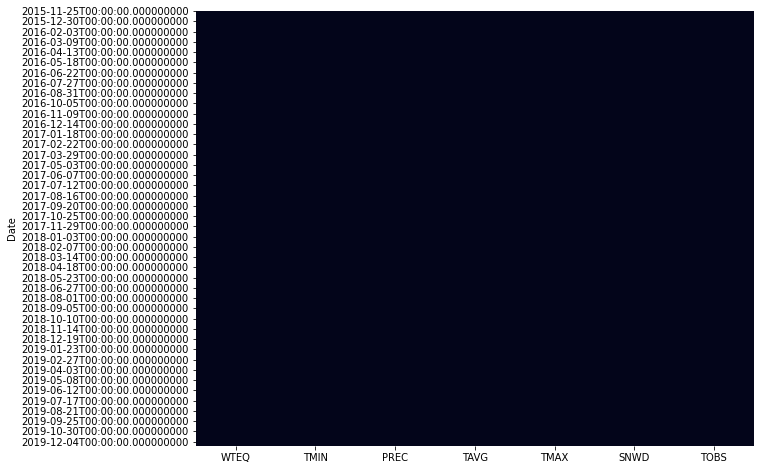

In [267]:
ST.datanullsHeatmap()

In [260]:
ST.hampelFilter('WTEQ')

In [282]:
ST.isolationForests('SNWD')

In [286]:
ST.zscore('TAVG', seasonal_decomp=True)

In [227]:
ST.LocalOutlierFactor('WTEQ')

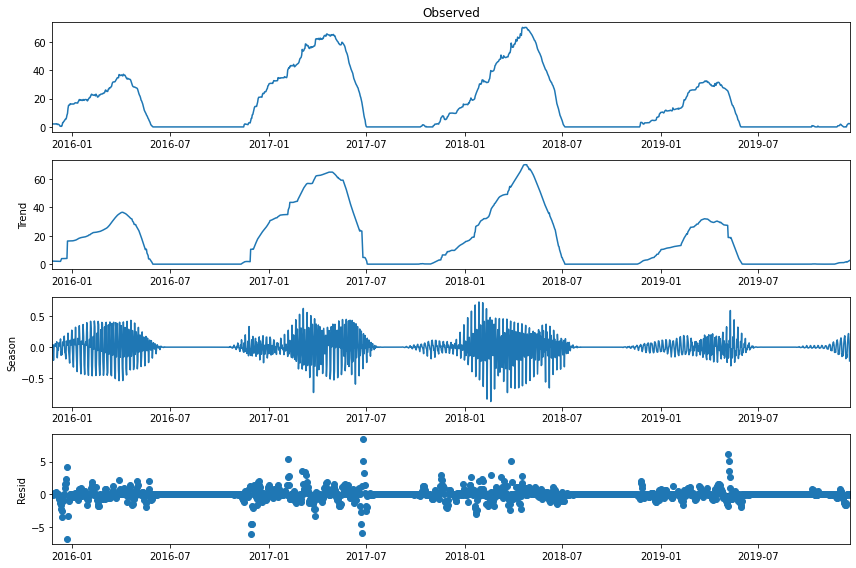

In [251]:
ST.seasonal_decompositions('WTEQ', method='STL')

In [231]:
# getData(['AGP:CA:MSNT'], 'WTEQ', '11/25/1989', '12/18/2019')

In [ ]:
# getData(['AGP:CA:MSNT'], 'PREC', '11/25/1995', '12/18/1995')